--- Análise da Estratégia Financeira (Valores por Pacote Unitário) ---
Premissa de Câmbio Inicial (S0): BRL/USD 5.40
Strike da Call (K): BRL/USD 5.80

Prêmio Recebido pela Venda da Call: BRL 0.1263
Investimento no Título: BRL 89.95
Investimento em USD: BRL 5.40
------------------------------
Investimento Total Bruto: BRL 95.35
Fluxo de Caixa Inicial Líquido: BRL -95.22

Lucro Máximo por Pacote (se BRL/USD >= 5.80): BRL 10.58
Lucro Máximo Total (100.000 pacotes): BRL 1,057,633.18

Lucro Mínimo por Pacote (pior cenário cambial): BRL 9.28
Lucro Mínimo Total (100.000 pacotes): BRL 927,633.18

AVISO: Os cálculos acima assumem que o título corporativo NÃO sofra default.


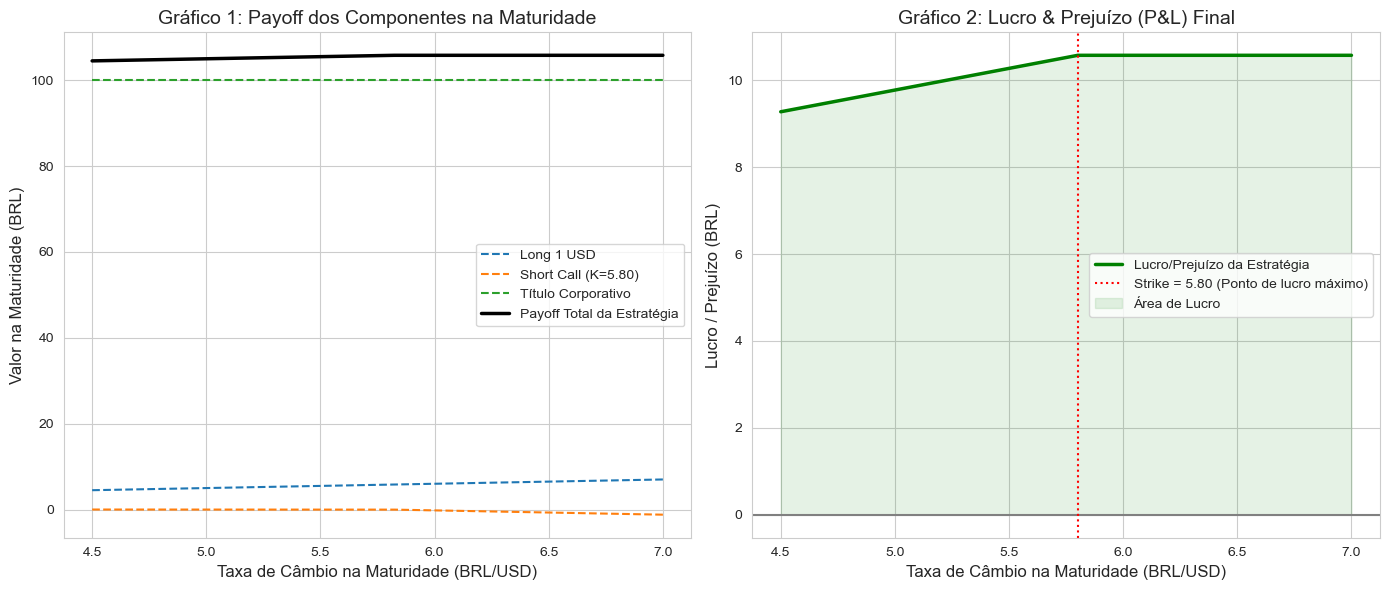

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# --- Parâmetros e Premissas ---
S0 = 5.40      # Taxa de câmbio BRL/USD atual (premissa)
K = 5.80       # Preço de exercício (Strike) da call
T = 0.5        # Maturidade em anos (6 meses)
r_brl = 0.105  # Taxa de juros livre de risco no Brasil (SELIC, premissa)
r_usd = 0.0525 # Taxa de juros livre de risco nos EUA (Fed Funds, premissa)
sigma = 0.15   # Volatilidade implícita do par BRL/USD (premissa)
bond_notional = 100.00 # Valor de face do título em BRL
bond_price = 89.95     # Preço de compra (investimento inicial) do título em BRL

# Estratégia
num_packages = 100000  # Quantidade de pacotes unitários

# --- Funções Auxiliares ---

def garman_kohlhagen_call(S, K, T, r_d, r_f, sigma):
    """Calcula o prêmio de uma call de câmbio (Garman-Kohlhagen)."""
    d1 = (np.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-r_f * T) * norm.cdf(d1) - K * np.exp(-r_d * T) * norm.cdf(d2)
    return call_price

# --- Cálculos da Estratégia Unitária ---

# 1. Calcular o prêmio recebido pela venda da call
call_premium = garman_kohlhagen_call(S0, K, T, r_brl, r_usd, sigma)

# 2. Calcular o investimento inicial líquido por pacote
#    (Custo de comprar 1 USD + Custo do título - Prêmio recebido)
initial_investment_usd = S0
initial_investment_bond = bond_price
total_initial_investment = initial_investment_usd + initial_investment_bond
net_initial_cashflow = call_premium - total_initial_investment

# 3. Criar um intervalo de possíveis taxas de câmbio na maturidade (ST)
ST_range = np.linspace(4.5, 7.0, 1000)

# 4. Calcular os payoffs na maturidade para cada componente
payoff_long_usd = ST_range
payoff_short_call = -np.maximum(ST_range - K, 0)
payoff_bond = np.full_like(ST_range, bond_notional)
payoff_total = payoff_long_usd + payoff_short_call + payoff_bond

# 5. Calcular o Lucro/Prejuízo (P&L) final da estratégia
#    P&L = Valor Total na Maturidade - Investimento Inicial Total + Prêmio Recebido
#    P&L = payoff_total + net_initial_cashflow
pnl_total = payoff_total - total_initial_investment + call_premium


# --- Exibindo Resultados e Gráficos ---

print("--- Análise da Estratégia Financeira (Valores por Pacote Unitário) ---")
print(f"Premissa de Câmbio Inicial (S0): BRL/USD {S0:.2f}")
print(f"Strike da Call (K): BRL/USD {K:.2f}\n")
print(f"Prêmio Recebido pela Venda da Call: BRL {call_premium:.4f}")
print(f"Investimento no Título: BRL {initial_investment_bond:.2f}")
print(f"Investimento em USD: BRL {initial_investment_usd:.2f}")
print("-" * 30)
print(f"Investimento Total Bruto: BRL {total_initial_investment:.2f}")
print(f"Fluxo de Caixa Inicial Líquido: BRL {net_initial_cashflow:.2f}\n")

# Ponto de lucro máximo (quando ST >= K)
max_profit = pnl_total[ST_range >= K][0]
print(f"Lucro Máximo por Pacote (se BRL/USD >= {K:.2f}): BRL {max_profit:.2f}")
print(f"Lucro Máximo Total (100.000 pacotes): BRL {max_profit * num_packages:,.2f}\n")

# Ponto de lucro mínimo (quando ST -> 0)
min_profit = pnl_total[0]
print(f"Lucro Mínimo por Pacote (pior cenário cambial): BRL {min_profit:.2f}")
print(f"Lucro Mínimo Total (100.000 pacotes): BRL {min_profit * num_packages:,.2f}")
print("\nAVISO: Os cálculos acima assumem que o título corporativo NÃO sofra default.")


# Configuração do Estilo dos Gráficos
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Gráfico 1: Payoff dos Componentes na Maturidade
plt.subplot(1, 2, 1)
plt.plot(ST_range, payoff_long_usd, label='Long 1 USD', linestyle='--')
plt.plot(ST_range, payoff_short_call, label=f'Short Call (K={K:.2f})', linestyle='--')
plt.plot(ST_range, payoff_bond, label='Título Corporativo', linestyle='--')
plt.plot(ST_range, payoff_total, label='Payoff Total da Estratégia', color='black', linewidth=2.5)
plt.title('Gráfico 1: Payoff dos Componentes na Maturidade', fontsize=14)
plt.xlabel('Taxa de Câmbio na Maturidade (BRL/USD)', fontsize=12)
plt.ylabel('Valor na Maturidade (BRL)', fontsize=12)
plt.legend()
plt.grid(True)

# Gráfico 2: Lucro & Prejuízo (P&L) da Estratégia
plt.subplot(1, 2, 2)
plt.plot(ST_range, pnl_total, label='Lucro/Prejuízo da Estratégia', color='green', linewidth=2.5)
plt.axhline(0, color='grey', linestyle='-')
plt.axvline(K, color='red', linestyle=':', label=f'Strike = {K:.2f} (Ponto de lucro máximo)')
plt.fill_between(ST_range, pnl_total, where=(pnl_total > 0), color='green', alpha=0.1, label='Área de Lucro')
plt.title('Gráfico 2: Lucro & Prejuízo (P&L) Final', fontsize=14)
plt.xlabel('Taxa de Câmbio na Maturidade (BRL/USD)', fontsize=12)
plt.ylabel('Lucro / Prejuízo (BRL)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()